<a href="https://colab.research.google.com/github/WeimusT/Quantitative_trading/blob/main/pair-trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import yfinance as yf
import matplotlib.pyplot as plt

import statsmodels.api as sm

In [2]:
# !pip install yfinance


In [3]:
gld = yf.Ticker("GLD")
gdx = yf.Ticker("GDX")

gld_history = gld.history(period="3y")
gdx_history = gdx.history(period="3y")

In [5]:
history = pd.merge(
    gld_history[["Close"]], gdx_history[["Close"]], 
    left_index=True, right_index=True, 
    suffixes=('_GLD', '_GDX')
)
history

,Close_GLD,Close_GDX
Date,,
2020-05-15 00:00:00-04:00,163.929993,35.159744
2020-05-18 00:00:00-04:00,162.690002,34.544426
2020-05-19 00:00:00-04:00,164.259995,35.775063
2020-05-20 00:00:00-04:00,164.649994,35.198208
2020-05-21 00:00:00-04:00,162.250000,34.284836
...,...,...
2023-05-09 00:00:00-04:00,189.020004,35.250000
2023-05-10 00:00:00-04:00,188.750000,35.000000
2023-05-11 00:00:00-04:00,187.130005,33.520000


<ipython-input-6-f552c37beda7>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


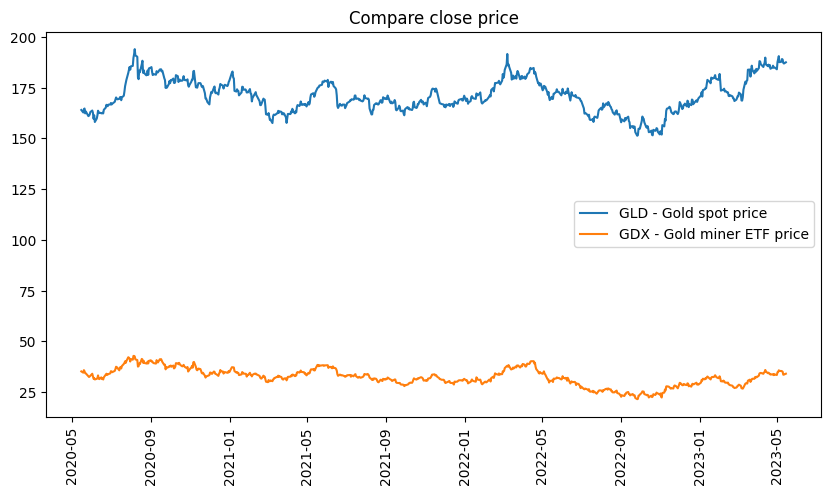

In [6]:
fig, ax = plt.subplots(figsize=[10, 5])

ax.plot(history.Close_GLD, label="GLD - Gold spot price")
ax.plot(history.Close_GDX, label="GDX - Gold miner ETF price")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title("Compare close price")
ax.legend()

Build train and test set for backtesting strategy. All parameters are estimated on the train set.

In [7]:
trainset = np.arange(0, 252 * 2)
testset = np.arange(trainset.shape[0], history.shape[0])
print("Train set range: ", np.min(trainset), ",", np.max(trainset))
print("Test set range: ", np.min(testset), ",", np.max(testset))

Train set range:  0 , 503
Test set range:  504 , 754


Use a regression to find hedge ratio between GDX and GLD on the train set. In this example the spread ratio is used to normalize the price spread and to find trading signals.

In [8]:
model = sm.OLS(
    history.loc[:, "Close_GLD"].iloc[trainset],
    history.loc[:, "Close_GDX"].iloc[trainset]
)
results = model.fit()

hedge_ratio = results.params["Close_GDX"] 
print("Hedge ratio: %.2f" % hedge_ratio)

Hedge ratio: 4.99


In [9]:
# Hedge = GLD - hedge_ratio * GDX
spread = history.loc[:, "Close_GLD"] - hedge_ratio * history.loc[:, "Close_GDX"]

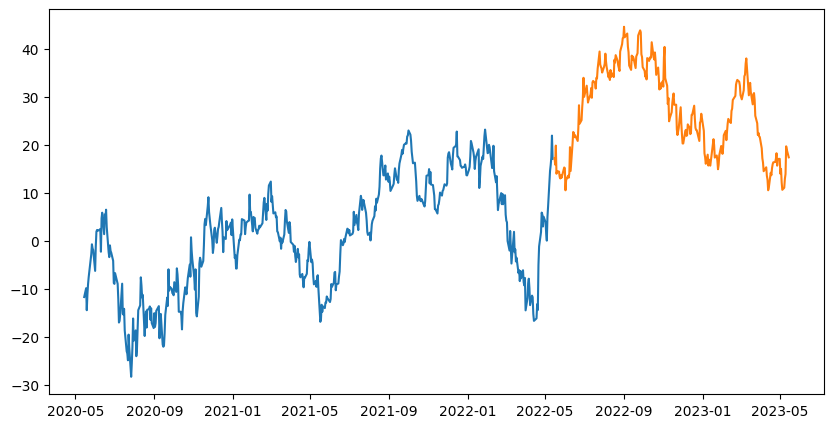

In [10]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(spread.iloc[trainset])
ax.plot(spread.iloc[testset])

Text(0.5, 1.0, 'Spread density')

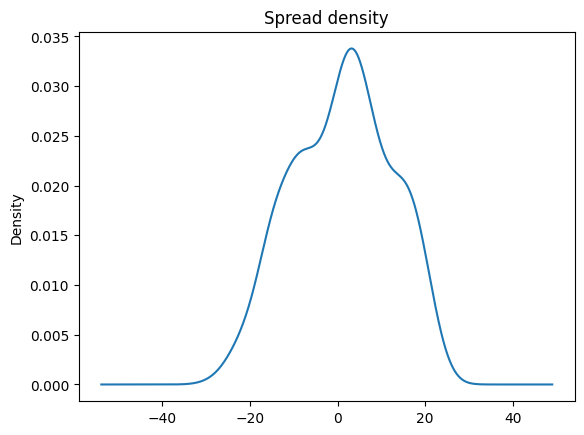

In [10]:
# Spread 
ax = spread.iloc[trainset].plot.kde()
ax.set_title("Spread density")

In [12]:
dailyret = history.loc[:, ("Close_GLD", "Close_GDX")].pct_change()
dailyret

,Close_GLD,Close_GDX
Date,,
2020-05-15 00:00:00-04:00,NaN,NaN
2020-05-18 00:00:00-04:00,-0.007564,-0.017501
2020-05-19 00:00:00-04:00,0.009650,0.035625
2020-05-20 00:00:00-04:00,0.002374,-0.016124
2020-05-21 00:00:00-04:00,-0.014576,-0.025949
...,...,...
2023-05-09 00:00:00-04:00,0.007086,-0.003111
2023-05-10 00:00:00-04:00,-0.001428,-0.007092
2023-05-11 00:00:00-04:00,-0.008583,-0.042286


## Naive Bollinger Band

Perform short spread when the spread is more than 2 std away from its mean. In this case GLD is potentially over-priced. Short GLD and long GDX.

Perform long spread when the spread is more than -2 std away from its mean. In this case GLD is potentially under-priced. Long GLD and short GDX.

In [13]:
spread_mean = np.mean(spread.iloc[trainset])
spread_std = np.std(spread.iloc[trainset])
print(f"Spread mean: {spread_mean:.4f}")
print(f"Spread std: {spread_std:.4f}")

Spread mean: 1.0142
Spread std: 11.3127


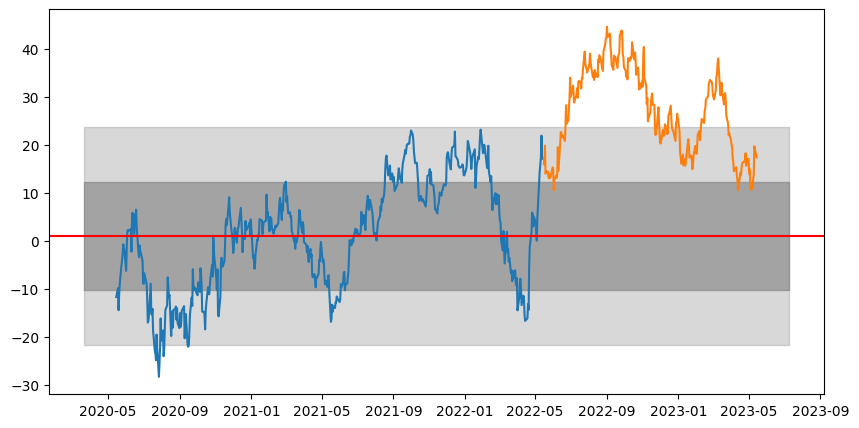

In [14]:
fig, ax = plt.subplots(figsize=[10, 5])
ax.plot(spread.iloc[trainset])
ax.plot(spread.iloc[testset])
ax.axhline(spread_mean, color="red")
z2_upper, z2_lower = spread_mean  + 2 * spread_std, spread_mean - 2 * spread_std
z1_upper, z1_lower = spread_mean  + 1 * spread_std, spread_mean - 1 * spread_std
x_min, x_max = ax.get_xlim()
ax.fill_between([x_min, x_max], z2_upper, z2_lower, alpha=0.3, color="gray")
ax.fill_between([x_min, x_max], z1_upper, z1_lower, alpha=0.6, color="gray")

In [15]:
# Use spread z-score to find trading signals
naive_stg = history.copy()
naive_stg["zscore"] = (spread - spread_mean) / spread_std
naive_stg["positions_GLD_Long"] = 0
naive_stg["positions_GDX_Long"] = 0
naive_stg["positions_GLD_Short"] = 0
naive_stg["positions_GDX_Short"] = 0

In [16]:
naive_stg.loc[naive_stg.zscore >= 1, ('positions_GLD_Short', 'positions_GDX_Short')] = [-1, 1] # Short spread
naive_stg.loc[naive_stg.zscore <= -1, ('positions_GLD_Long', 'positions_GDX_Long')] = [1, -1] # Buy spread
naive_stg.loc[naive_stg.zscore <= 0.5, ('positions_GLD_Short', 'positions_GDX_Short')] = 0 # Exit short spread
naive_stg.loc[naive_stg.zscore >= -0.5, ('positions_GLD_Long', 'positions_GDX_Long')] = 0 # Exit long spread
naive_stg.fillna(method="ffill", inplace=True) # Ensure existing positions are carried forward unless there is an exit signal
naive_stg

,Close_GLD,Close_GDX,zscore,positions_GLD_Long,positions_GDX_Long,positions_GLD_Short,positions_GDX_Short
Date,,,,,,,
2020-05-15 00:00:00-04:00,163.929993,35.159744,-1.121447,1,-1,0,0
2020-05-18 00:00:00-04:00,162.690002,34.544426,-0.959402,0,0,0,0
2020-05-19 00:00:00-04:00,164.259995,35.775063,-1.363931,1,-1,0,0
2020-05-20 00:00:00-04:00,164.649994,35.198208,-1.074782,1,-1,0,0
2020-05-21 00:00:00-04:00,162.250000,34.284836,-0.883690,0,0,0,0
...,...,...,...,...,...,...,...
2023-05-09 00:00:00-04:00,189.020004,35.250000,1.056572,0,0,-1,1
2023-05-10 00:00:00-04:00,188.750000,35.000000,1.143076,0,0,-1,1
2023-05-11 00:00:00-04:00,187.130005,33.520000,1.653277,0,0,-1,1


In [17]:
positions_Long = naive_stg.loc[:, ("positions_GLD_Long", "positions_GDX_Long")]
positions_Short = naive_stg.loc[:, ("positions_GLD_Short", "positions_GDX_Short")]
positions = pd.DataFrame(np.array(positions_Long) + np.array(positions_Short), index=naive_stg.index)
positions

,0,1
Date,,
2020-05-15 00:00:00-04:00,1,-1
2020-05-18 00:00:00-04:00,0,0
2020-05-19 00:00:00-04:00,1,-1
2020-05-20 00:00:00-04:00,1,-1
2020-05-21 00:00:00-04:00,0,0
...,...,...
2023-05-09 00:00:00-04:00,-1,1
2023-05-10 00:00:00-04:00,-1,1
2023-05-11 00:00:00-04:00,-1,1


The Sharpe on trainset is more significant than test set sharpe. This strategy is overfitted on the trainset.

In [18]:
naive_pnl = (np.array(positions.shift()) * np.array(dailyret)).sum(axis=1) # Profit and loss
sharpe_trainset = np.sqrt(252) * np.mean(naive_pnl[trainset[1:]]) / np.std(naive_pnl[trainset[1:]])
sharpe_testset = np.sqrt(252) * np.mean(naive_pnl[testset]) / np.std(naive_pnl[testset])

print("Train Sharpe %.4f" % sharpe_trainset)
print("Test Sharpe %.4f" % sharpe_testset)

Train Sharpe 1.8409
Test Sharpe 0.4185


The pair trading strategy using +/- 1 std as trading signals, and +/- 0.5 std as the exit signals over fits to the train set. At the end of train set, this strategy achieved 150% profitability. At the end of test set, this strategy only achieved 110% profitability.

## Bollinger Band

Use rolling mean and standard deviation to identify entry and exit point.

In [19]:
stg_param_window = 30 # Lookback window
stg_param_entry= 1 # Entry zscore threshold
stg_param_exit = 0.5 # Exist zscore threshold

bollinger = history.copy()
bollinger.loc[:, "Spread"] = spread
bollinger.loc[:, "Spread_SMA"] = bollinger.loc[:, "Spread"].rolling(window=stg_param_window).mean().values
bollinger.loc[:, "Spread_STD"] = bollinger.loc[:, "Spread"].rolling(window=stg_param_window).std().values
bollinger = bollinger.eval("zscore = (Spread - Spread_SMA) / Spread_STD")
# Spread = GLD_Close - Spread * GDX_Close
bollinger.loc[bollinger.zscore >= stg_param_entry, ["Positions_GLD_Short", "Positions_GDX_Short"]] = [-1, 1] # Short Gold
bollinger.loc[bollinger.zscore <= -stg_param_entry, ["Positions_GLD_Long", "Positions_GDX_Long"]] = [1, -1] # Long Gold
bollinger.loc[bollinger.zscore <= stg_param_exit, ["Positions_GLD_Short", "Positions_GDX_Short"]] = [0, 0] # Exit short
bollinger.loc[bollinger.zscore >= -stg_param_exit, ["Positions_GLD_Long", "Positions_GDX_Long"]] = [0, 0] # Exit short
bollinger.loc[:, ["Positions_GLD_Short", "Positions_GDX_Short", "Positions_GLD_Long", "Positions_GDX_Long"]] = (
    bollinger.loc[:, ["Positions_GLD_Short", "Positions_GDX_Short", "Positions_GLD_Long", "Positions_GDX_Long"]]
    .fillna(method="ffill")
)
bollinger.loc[:, ["Positions_GLD_Short", "Positions_GDX_Short", "Positions_GLD_Long", "Positions_GDX_Long"]] = (
    bollinger.loc[:, ["Positions_GLD_Short", "Positions_GDX_Short", "Positions_GLD_Long", "Positions_GDX_Long"]]
    .fillna(0)
)
bollinger = bollinger.eval('''
  Positions_GLD = Positions_GLD_Short + Positions_GLD_Long
  Positions_GDX = Positions_GDX_Short + Positions_GDX_Long
''')

bollinger

,Close_GLD,Close_GDX,Spread,Spread_SMA,Spread_STD,zscore,Positions_GLD_Short,Positions_GDX_Short,Positions_GLD_Long,Positions_GDX_Long,Positions_GLD,Positions_GDX
Date,,,,,,,,,,,,
2020-05-15 00:00:00-04:00,163.929993,35.159744,-11.672361,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-18 00:00:00-04:00,162.690002,34.544426,-9.839196,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-19 00:00:00-04:00,164.259995,35.775063,-14.415514,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-20 00:00:00-04:00,164.649994,35.198208,-11.144463,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2020-05-21 00:00:00-04:00,162.250000,34.284836,-8.982698,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-09 00:00:00-04:00,189.020004,35.250000,12.966876,15.727497,3.356702,-0.822420,0.0,0.0,1.0,-1.0,1.0,-1.0
2023-05-10 00:00:00-04:00,188.750000,35.000000,13.945476,15.456664,3.148607,-0.479955,0.0,0.0,0.0,0.0,0.0,0.0
2023-05-11 00:00:00-04:00,187.130005,33.520000,19.717213,15.363607,2.969128,1.466291,-1.0,1.0,0.0,0.0,-1.0,1.0


In [20]:
# Return
positions = bollinger.loc[:, ["Positions_GLD", "Positions_GDX"]]

bollinger_pnl = (np.array(positions.shift()) * np.array(dailyret)).sum(axis=1) # Profit and loss
sharpe_trainset = np.sqrt(252) * np.mean(bollinger_pnl[trainset[1:]]) / np.std(bollinger_pnl[trainset[1:]])
sharpe_testset = np.sqrt(252) * np.mean(bollinger_pnl[testset]) / np.std(bollinger_pnl[testset])

print("Train Sharpe %.4f" % sharpe_trainset)
print("Test Sharpe %.4f" % sharpe_testset)

Train Sharpe 0.1853
Test Sharpe 0.4902


In [32]:
# Buy and hold
bh_pnl = dailyret.sum(axis=1).values


In [34]:
testset

array([504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516,
       517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529,
       530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542,
       543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555,
       556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568,
       569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581,
       582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594,
       595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607,
       608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620,
       621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633,
       634, 635, 636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646,
       647, 648, 649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659,
       660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672,
       673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 68

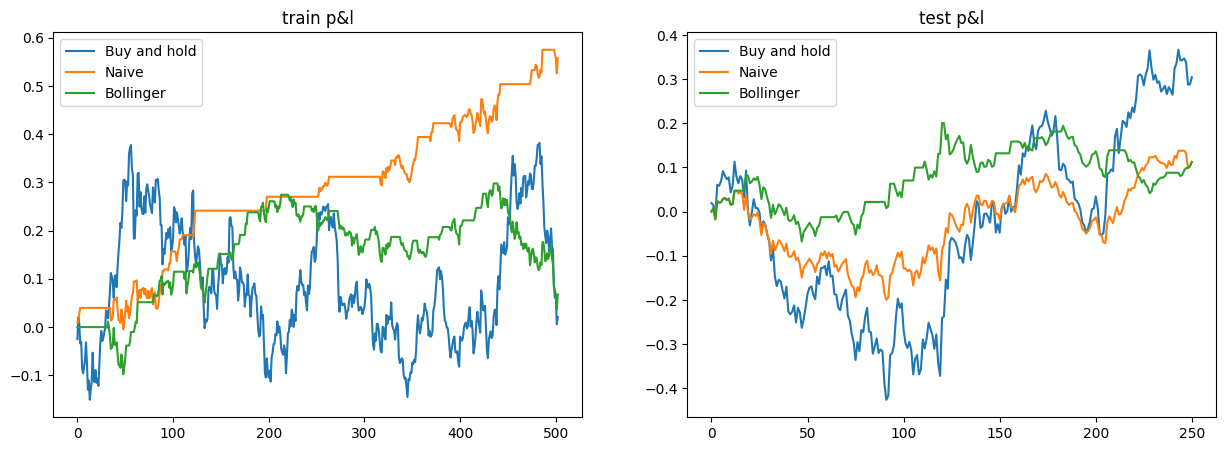

In [36]:
fig, axes = plt.subplots(1, 2, figsize=[15, 5])
ax0 = axes[0]
ax0.set_title("train p&l")
ax0.plot(np.cumsum(bh_pnl[trainset[1:]]), label="Buy and hold")
ax0.plot(np.cumsum(naive_pnl[trainset[1:]]), label="Naive")
ax0.plot(np.cumsum(bollinger_pnl[trainset[1:]]), label="Bollinger")
ax0.legend()
ax1 = axes[1]
ax1.set_title("test p&l")
ax1.plot(np.cumsum(bh_pnl[testset]), label="Buy and hold")
ax1.plot(np.cumsum(naive_pnl[testset]), label="Naive")
ax1.plot(np.cumsum(bollinger_pnl[testset]), label="Bollinger")
ax1.legend()